In [8]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, PolynomialFeatures, StandardScaler, SplineTransformer, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc, recall_score, precision_recall_curve, make_scorer, accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.kernel_approximation import Nystroem
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier

import pickle
from pickle import dump, load

# Pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchviz
from torchviz import make_dot, make_dot_from_trace
from tqdm.notebook import tqdm
import tqdm

import skorch
from skorch import NeuralNetClassifier

In [2]:
print('The torch version is {}.'.format(torch.__version__))
print('The tqdm is {}.'.format(tqdm.__version__))
print('The skorch is {}.'.format(skorch.__version__))

The torch version is 2.2.2+cpu.
The tqdm is 4.66.2.
The skorch is 1.0.0.


In [3]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [4]:
# Recodage variable cible grav par ordre croissant : 0 : indemne, 1 : blessé léger, 2 : blessé grave, 3 : décès
with pd.option_context("future.no_silent_downcasting", True):
    df['grav'] = df['grav'].replace(1,'I')
    df['grav'] = df['grav'].replace(2,'T')
    df['grav'] = df['grav'].replace(3,'BG')
    df['grav'] = df['grav'].replace(4,'BL')
    df['grav'] = df['grav'].replace('I',0)
    df['grav'] = df['grav'].replace('T',3)
    df['grav'] = df['grav'].replace('BG',2)
    df['grav'] = df['grav'].replace('BL',1)

In [5]:
data = df.drop(['grav_rec', 'an', 'jour', 'date', 'dep', 'grav'], axis=1)
y = df.grav

numerical_features = ['age_usager', 'mois', 'heure', 'lat', 'long']
categorical_features = [col for col in data.columns if col not in numerical_features]
for col in categorical_features:
    data[col] = data[col].astype('int')
data[categorical_features] = data[categorical_features].astype('int')


In [6]:
class TransfoHour(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo[f'{self.column_name}_cos'] = np.cos(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass

class TransfoMonth(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo[f'{self.column_name}_cos'] = np.cos((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass


preprocessor = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', MinMaxScaler(), ['age_usager'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42, stratify=y)
data_train, data_val, y_train, y_val = train_test_split(data_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

data_process_train = preprocessor.fit_transform(data_train)
data_process_val = preprocessor.transform(data_val)
data_process_test = preprocessor.transform(data_test)

display(data_process_train.head())

,transfo_heure__heure_sin,transfo_heure__heure_cos,transfo_mois__mois_sin,transfo_mois__mois_cos,transfo_lat_long__lat,transfo_lat_long__long,transfo_age_usager__age_usager,remainder__lum,remainder__agg,remainder__int,...,remainder__eq_ceinture,remainder__eq_casque,remainder__eq_siege,remainder__eq_gilet,remainder__eq_airbag,remainder__eq_gants,remainder__eq_indetermine,remainder__eq_autre,remainder__jour_chome,remainder__prox_pt_choc
367203,1.224647e-16,-1.000000,0.000000e+00,1.000000e+00,0.291093,0.027916,0.609091,0,1,0,...,0,0,0,0,0,0,1,0,1,0
165009,-9.659258e-01,-0.258819,8.660254e-01,-5.000000e-01,0.676458,-0.006907,0.381818,0,0,1,...,1,0,0,0,0,0,0,0,1,0
102923,-5.000000e-01,-0.866025,8.660254e-01,-5.000000e-01,0.271712,-0.046623,0.381818,0,1,1,...,0,1,0,0,0,1,0,0,1,1
389410,-8.660254e-01,-0.500000,1.000000e+00,6.123234e-17,0.201869,1.542802,0.209091,0,1,1,...,1,0,0,0,0,0,1,0,0,0
85702,8.660254e-01,-0.500000,1.224647e-16,-1.000000e+00,-0.047079,-0.248779,0.509091,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
dump(preprocessor,open('../../../data/saved_models/' + 'preprocessor_pytorch.pkl','wb'))

In [9]:
BATCH_SIZE = 64
NUM_FEATURES = len(data_process_train.columns)
NUM_CLASSES = 4
print((f"Batch size : {BATCH_SIZE}, Nb features : {NUM_FEATURES},  Nb classes : {NUM_CLASSES}"))

data_process_train = torch.tensor(data_process_train.values, dtype=torch.float32).to(device)
data_process_val = torch.tensor(data_process_val.values, dtype=torch.float32).to(device)
data_process_test = torch.tensor(data_process_test.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.astype('int').values, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val.astype('int').values, dtype=torch.float32).to(device)

,transfo_heure__heure_sin,transfo_heure__heure_cos,transfo_mois__mois_sin,transfo_mois__mois_cos,transfo_lat_long__lat,transfo_lat_long__long,transfo_age_usager__age_usager,remainder__lum,remainder__agg,remainder__int,...,remainder__eq_ceinture,remainder__eq_casque,remainder__eq_siege,remainder__eq_gilet,remainder__eq_airbag,remainder__eq_gants,remainder__eq_indetermine,remainder__eq_autre,remainder__jour_chome,remainder__prox_pt_choc
367203,1.224647e-16,-1.000000,0.000000e+00,1.000000e+00,0.291093,0.027916,0.609091,0,1,0,...,0,0,0,0,0,0,1,0,1,0
165009,-9.659258e-01,-0.258819,8.660254e-01,-5.000000e-01,0.676458,-0.006907,0.381818,0,0,1,...,1,0,0,0,0,0,0,0,1,0
102923,-5.000000e-01,-0.866025,8.660254e-01,-5.000000e-01,0.271712,-0.046623,0.381818,0,1,1,...,0,1,0,0,0,1,0,0,1,1
389410,-8.660254e-01,-0.500000,1.000000e+00,6.123234e-17,0.201869,1.542802,0.209091,0,1,1,...,1,0,0,0,0,0,1,0,0,0
85702,8.660254e-01,-0.500000,1.224647e-16,-1.000000e+00,-0.047079,-0.248779,0.509091,0,1,1,...,0,0,0,0,0,0,0,0,0,0


Batch size : 64, Nb features : 37,  Nb classes : 4


In [10]:
print("train: ", data_process_train.shape)
print("test:", data_process_test.shape)
print("val:", data_process_val.shape)

train:  torch.Size([281695, 37])
test: torch.Size([134141, 37])
val: torch.Size([31300, 37])


In [11]:
class TabularDataset(Dataset):
    def __init__(self, data, labels=None):
        """
        Characterizes a Dataset for PyTorch
        """
        self.n = data.shape[0]
        self.data = data
        self.y = labels

    def __len__(self):
        """
        Denotes the total number of samples.
        """
        return self.n

    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        return [self.data[idx], self.y[idx].long()]

In [12]:
train = TabularDataset(data=data_process_train, labels=y_train)
val = TabularDataset(data=data_process_val, labels=y_val)
test = TabularDataset(data=data_process_test, labels=y_test)


In [13]:
train_dl = DataLoader(train, BATCH_SIZE, shuffle = True)
val_dl = DataLoader(val, 1, shuffle = False)
test_dl = DataLoader(test, 1, shuffle = False)

In [14]:
class Multiclass(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super().__init__()
        self.layer1 = nn.Linear(37, 70)
        self.layer2 = activation()
        self.layer3 = nn.Linear(70, 140)
        self.layer4 = activation()
        self.layer5 = nn.Dropout(p=0.2)
        self.layer6 = nn.Linear(140, 70)
        self.layer7 = activation()
        self.layer8 = nn.Linear(70, 35)
        self.layer9 = activation()
        self.layer10 = nn.Dropout(p=0.2)
        self.layer11= nn.Linear(35, 14)
        self.layer12= activation()
        self.layer13= nn.Linear(14, 4)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        return F.softmax(x, dim=1)

In [15]:
# loss metric and optimizer
LEARNING_RATE = 0.1
model = Multiclass().to(device)
class_weights = []
for i in range(4):
  Nb_class = y_train[y_train == i].shape[0]
  class_weights.append(y_train.shape[0] / (4*Nb_class))
class_weights = [class_weights[i] for i in range(len(class_weights))]
class_weights = torch.FloatTensor(class_weights).to(device)
print("class_weights:", class_weights)
loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction='mean').to(device)

#loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.25, patience=2, threshold=0.001, min_lr=1e-4)

class_weights: tensor([0.6057, 0.6197, 1.5969, 9.1614])


In [16]:
# Forward pass
logits = model(data_process_train)
print('logits:', logits[:5])

logits: tensor([[0.3139, 0.2573, 0.2239, 0.2050],
        [0.3162, 0.2565, 0.2227, 0.2046],
        [0.3161, 0.2612, 0.2172, 0.2055],
        [0.3180, 0.2571, 0.2189, 0.2060],
        [0.3170, 0.2582, 0.2193, 0.2055]], grad_fn=<SliceBackward0>)


In [17]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    epoch_f1 = []
    for i, batch in enumerate(tqdm.tqdm(data_loader, desc="training...")):
        data, labels = batch
        data, labels = data.to(device), labels.to(device)
        prediction = model(data)
        loss = criterion(prediction, labels)
        accuracy = get_accuracy(prediction, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        f1 = f1_score(labels, prediction.argmax(dim=-1), average='weighted')
        epoch_f1.append(f1)

    return np.mean(epoch_losses), np.mean(epoch_accs), np.mean(epoch_f1)

In [18]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    epoch_f1 = []
    with torch.no_grad():
        for i, batch in enumerate(tqdm.tqdm(data_loader, desc="evaluating...")):
            data, labels = batch
            data, labels = data.to(device), labels.to(device)
            prediction = model(data)
            loss = criterion(prediction, labels)
            accuracy = get_accuracy(prediction, labels)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            f1 = f1_score(labels, prediction.argmax(dim=-1), average='weighted')
            epoch_f1.append(f1)
        scheduler.step(np.mean(epoch_f1))
        print("lr :", optimizer.param_groups[0]['lr'])
    return np.mean(epoch_losses), np.mean(epoch_accs), np.mean(epoch_f1)

In [19]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [20]:
n_epochs = 31
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc, train_f1 = train(train_dl, model, loss_fn, optimizer, device)
    valid_loss, valid_acc, valid_f1 = evaluate(val_dl, model, loss_fn, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "../../../data/saved_models/dict_model_pytorch.pt)
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}, train_f1: {train_f1:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}, valid_f1: {valid_f1:.3f}")

evaluating...: 100%|██████████| 31300/31300 [00:51<00:00, 606.59it/s]


lr : 0.1
epoch: 0
train_loss: 1.291, train_acc: 0.462, train_f1: 0.421
valid_loss: 1.207, valid_acc: 0.522, valid_f1: 0.522


evaluating...: 100%|██████████| 31300/31300 [00:52<00:00, 597.86it/s]


lr : 0.1
epoch: 1
train_loss: 1.227, train_acc: 0.528, train_f1: 0.542
valid_loss: 1.247, valid_acc: 0.467, valid_f1: 0.467


evaluating...: 100%|██████████| 31300/31300 [00:50<00:00, 613.84it/s]


lr : 0.1
epoch: 2
train_loss: 1.214, train_acc: 0.538, train_f1: 0.552
valid_loss: 1.207, valid_acc: 0.512, valid_f1: 0.512


evaluating...: 100%|██████████| 31300/31300 [00:51<00:00, 613.22it/s]


lr : 0.1
epoch: 3
train_loss: 1.208, train_acc: 0.541, train_f1: 0.558
valid_loss: 1.152, valid_acc: 0.574, valid_f1: 0.574


evaluating...: 100%|██████████| 31300/31300 [00:50<00:00, 614.71it/s]


lr : 0.1
epoch: 4
train_loss: 1.202, train_acc: 0.549, train_f1: 0.566
valid_loss: 1.153, valid_acc: 0.571, valid_f1: 0.571


evaluating...: 100%|██████████| 31300/31300 [00:50<00:00, 617.91it/s]


lr : 0.1
epoch: 5
train_loss: 1.194, train_acc: 0.560, train_f1: 0.573
valid_loss: 1.172, valid_acc: 0.549, valid_f1: 0.549


evaluating...: 100%|██████████| 31300/31300 [00:52<00:00, 601.31it/s]


lr : 0.1
epoch: 6
train_loss: 1.195, train_acc: 0.554, train_f1: 0.571
valid_loss: 1.139, valid_acc: 0.586, valid_f1: 0.586


evaluating...: 100%|██████████| 31300/31300 [00:51<00:00, 605.92it/s]


lr : 0.1
epoch: 7
train_loss: 1.191, train_acc: 0.560, train_f1: 0.576
valid_loss: 1.173, valid_acc: 0.552, valid_f1: 0.552


evaluating...: 100%|██████████| 31300/31300 [00:50<00:00, 614.65it/s]


lr : 0.1
epoch: 8
train_loss: 1.191, train_acc: 0.558, train_f1: 0.576
valid_loss: 1.184, valid_acc: 0.537, valid_f1: 0.537


evaluating...: 100%|██████████| 31300/31300 [00:51<00:00, 604.24it/s]


lr : 0.025
epoch: 9
train_loss: 1.186, train_acc: 0.566, train_f1: 0.581
valid_loss: 1.161, valid_acc: 0.563, valid_f1: 0.563


evaluating...: 100%|██████████| 31300/31300 [00:50<00:00, 622.16it/s]


lr : 0.025
epoch: 10
train_loss: 1.173, train_acc: 0.577, train_f1: 0.593
valid_loss: 1.154, valid_acc: 0.570, valid_f1: 0.570


evaluating...: 100%|██████████| 31300/31300 [00:58<00:00, 533.02it/s]


lr : 0.025
epoch: 11
train_loss: 1.170, train_acc: 0.581, train_f1: 0.595
valid_loss: 1.154, valid_acc: 0.573, valid_f1: 0.573


evaluating...: 100%|██████████| 31300/31300 [01:12<00:00, 429.47it/s]


lr : 0.025
epoch: 12
train_loss: 1.169, train_acc: 0.584, train_f1: 0.597
valid_loss: 1.136, valid_acc: 0.589, valid_f1: 0.589


evaluating...: 100%|██████████| 31300/31300 [01:11<00:00, 436.32it/s]


lr : 0.025
epoch: 13
train_loss: 1.169, train_acc: 0.583, train_f1: 0.597
valid_loss: 1.149, valid_acc: 0.578, valid_f1: 0.578


evaluating...: 100%|██████████| 31300/31300 [01:10<00:00, 441.53it/s]


lr : 0.025
epoch: 14
train_loss: 1.168, train_acc: 0.584, train_f1: 0.599
valid_loss: 1.165, valid_acc: 0.562, valid_f1: 0.562


evaluating...: 100%|██████████| 31300/31300 [01:12<00:00, 433.02it/s]


lr : 0.025
epoch: 15
train_loss: 1.168, train_acc: 0.585, train_f1: 0.598
valid_loss: 1.130, valid_acc: 0.599, valid_f1: 0.599


evaluating...: 100%|██████████| 31300/31300 [01:13<00:00, 426.35it/s]


lr : 0.025
epoch: 16
train_loss: 1.167, train_acc: 0.583, train_f1: 0.597
valid_loss: 1.150, valid_acc: 0.578, valid_f1: 0.578


evaluating...: 100%|██████████| 31300/31300 [01:12<00:00, 430.71it/s]


lr : 0.025
epoch: 17
train_loss: 1.167, train_acc: 0.584, train_f1: 0.599
valid_loss: 1.157, valid_acc: 0.570, valid_f1: 0.570


evaluating...: 100%|██████████| 31300/31300 [01:10<00:00, 442.31it/s]


lr : 0.00625
epoch: 18
train_loss: 1.167, train_acc: 0.587, train_f1: 0.601
valid_loss: 1.153, valid_acc: 0.572, valid_f1: 0.572


evaluating...: 100%|██████████| 31300/31300 [01:05<00:00, 477.38it/s]


lr : 0.00625
epoch: 19
train_loss: 1.162, train_acc: 0.588, train_f1: 0.602
valid_loss: 1.147, valid_acc: 0.580, valid_f1: 0.580


evaluating...: 100%|██████████| 31300/31300 [01:06<00:00, 472.50it/s]


lr : 0.00625
epoch: 20
train_loss: 1.161, train_acc: 0.590, train_f1: 0.603
valid_loss: 1.143, valid_acc: 0.583, valid_f1: 0.583


evaluating...: 100%|██████████| 31300/31300 [01:06<00:00, 472.13it/s]


lr : 0.0015625
epoch: 21
train_loss: 1.161, train_acc: 0.591, train_f1: 0.604
valid_loss: 1.144, valid_acc: 0.582, valid_f1: 0.582


evaluating...: 100%|██████████| 31300/31300 [01:05<00:00, 481.01it/s]


lr : 0.0015625
epoch: 22
train_loss: 1.159, train_acc: 0.592, train_f1: 0.605
valid_loss: 1.147, valid_acc: 0.579, valid_f1: 0.579


evaluating...: 100%|██████████| 31300/31300 [01:05<00:00, 480.54it/s]


lr : 0.0015625
epoch: 23
train_loss: 1.159, train_acc: 0.591, train_f1: 0.605
valid_loss: 1.145, valid_acc: 0.583, valid_f1: 0.583


evaluating...: 100%|██████████| 31300/31300 [01:06<00:00, 471.95it/s]


lr : 0.000390625
epoch: 24
train_loss: 1.159, train_acc: 0.592, train_f1: 0.605
valid_loss: 1.144, valid_acc: 0.583, valid_f1: 0.583


evaluating...: 100%|██████████| 31300/31300 [01:05<00:00, 479.11it/s]


lr : 0.000390625
epoch: 25
train_loss: 1.159, train_acc: 0.593, train_f1: 0.606
valid_loss: 1.144, valid_acc: 0.583, valid_f1: 0.583


evaluating...: 100%|██████████| 31300/31300 [01:06<00:00, 468.80it/s]


lr : 0.000390625
epoch: 26
train_loss: 1.159, train_acc: 0.592, train_f1: 0.606
valid_loss: 1.144, valid_acc: 0.584, valid_f1: 0.584


evaluating...: 100%|██████████| 31300/31300 [01:05<00:00, 477.02it/s]


lr : 0.0001
epoch: 27
train_loss: 1.159, train_acc: 0.593, train_f1: 0.606
valid_loss: 1.143, valid_acc: 0.585, valid_f1: 0.585


evaluating...: 100%|██████████| 31300/31300 [01:12<00:00, 434.35it/s]


lr : 0.0001
epoch: 28
train_loss: 1.159, train_acc: 0.594, train_f1: 0.607
valid_loss: 1.144, valid_acc: 0.584, valid_f1: 0.584


evaluating...: 100%|██████████| 31300/31300 [01:07<00:00, 462.61it/s]


lr : 0.0001
epoch: 29
train_loss: 1.158, train_acc: 0.593, train_f1: 0.606
valid_loss: 1.144, valid_acc: 0.584, valid_f1: 0.584


evaluating...: 100%|██████████| 31300/31300 [01:09<00:00, 452.15it/s]

lr : 0.0001
epoch: 30
train_loss: 1.158, train_acc: 0.593, train_f1: 0.607
valid_loss: 1.144, valid_acc: 0.584, valid_f1: 0.584


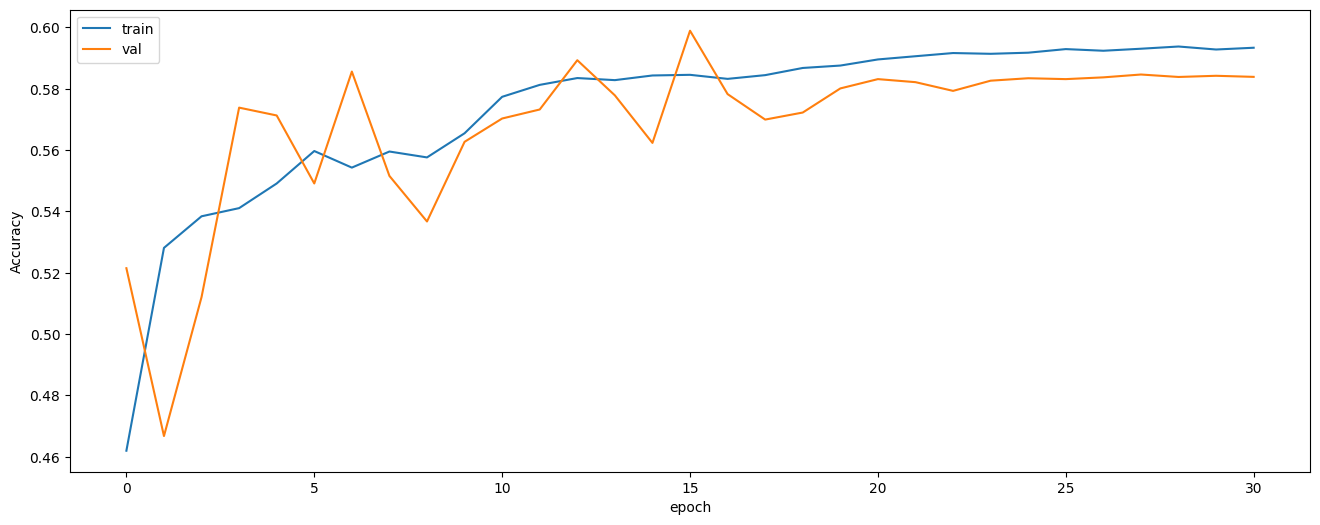

In [21]:
plt.figure(figsize=(16,6))
plt.plot(metrics['train_accs'], label='train');
plt.plot(metrics['valid_accs'], label='val');
plt.ylabel('Accuracy');
plt.xlabel('epoch');
plt.legend();

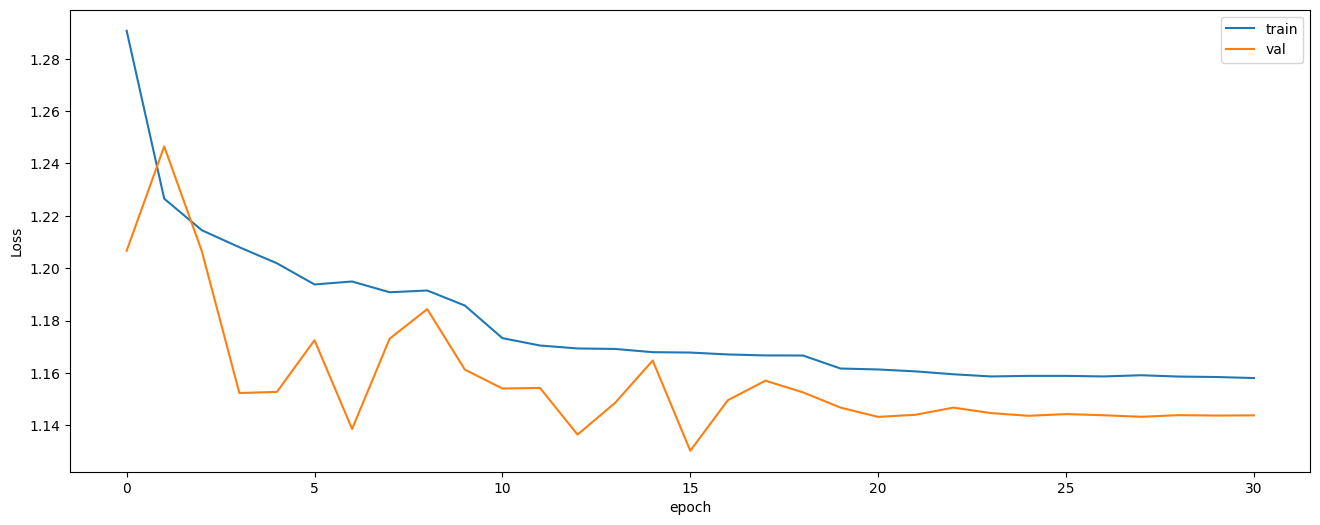

In [22]:
plt.figure(figsize=(16,6))
plt.plot(metrics['train_losses'], label='train');
plt.plot(metrics['valid_losses'], label='val');
plt.ylabel('Loss');
plt.xlabel('epoch');
plt.legend();

In [23]:
predictions = model(data_process_test)

In [24]:
y_pred = torch.argmax(torch.sigmoid(predictions),dim=1)
y_pred_df = pd.DataFrame(y_pred.numpy())
y_pred_df.value_counts()

0
0    58278
1    36504
2    25489
3    13870
Name: count, dtype: int64

In [25]:
print("Accuracy de l'ensemble d'entraînement :", get_accuracy(model(data_process_train), y_train))
print("Accuracy de l'ensemble de test :", get_accuracy(model(data_process_test), y_test))

Accuracy de l'ensemble d'entraînement : tensor(0.5949)
Accuracy de l'ensemble de test : tensor(0.5895)


In [26]:
cr= classification_report(y_test, y_pred, target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'])
print(cr)

                precision    recall  f1-score   support

      Indemnes       0.73      0.77      0.75     55365
Blessés légers       0.68      0.46      0.55     54116
Blessés graves       0.37      0.45      0.41     21000
          Tués       0.14      0.54      0.23      3660

      accuracy                           0.59    134141
     macro avg       0.48      0.56      0.48    134141
  weighted avg       0.64      0.59      0.60    134141



In [27]:
cr= classification_report(y_test, y_pred, target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'],output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
print(df_cr)
df_cr.to_csv('../../../data/img/' + 'dnn_pytorch_report' + '.csv')

                precision    recall  f1-score        support
Indemnes         0.732575  0.771119  0.751353   55365.000000
Blessés légers   0.683240  0.460880  0.550452   54116.000000
Blessés graves   0.370984  0.450286  0.406806   21000.000000
Tués             0.143547  0.543989  0.227153    3660.000000
accuracy         0.589536  0.589536  0.589536       0.589536
macro avg        0.482586  0.556569  0.483941  134141.000000
weighted avg     0.639993  0.589536  0.602062  134141.000000


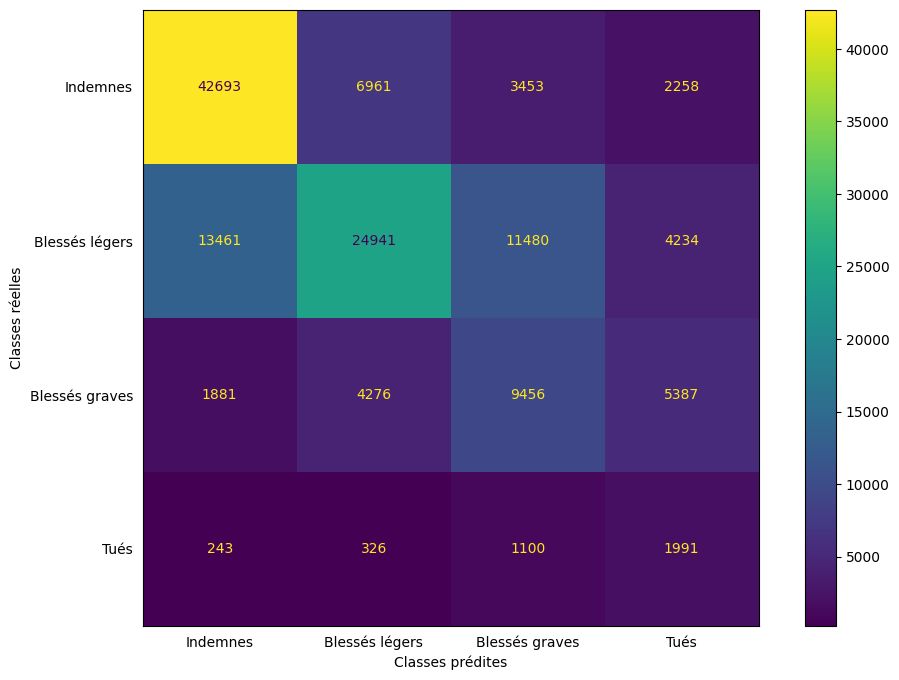

In [29]:
cm = confusion_matrix(y_test, y_pred) 
disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués']
    )

#disp.ax_.set(xlabel='Classes prédites', ylabel='Classes réelles')
disp.plot()
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')
plt.tick_params(left = False, bottom = False) 
plt.rcParams["figure.figsize"] = (13, 8)
plt.savefig('../../../data/img/' + f'dnn_pytorch_confusion_matrix' + '.jpg')

**Suppression des variables présentant un V de Cramer faible**

Il semblerait que les variables faiblement informatives puissent pénaliser les performances des réseaux de neurones. Il s'agit donc ici de regarder comment se comporte le réseau en supprimant certaines d'entre elles. 

In [108]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [109]:
# Recodage variable cible grav par ordre croissant : 0 : indemne, 1 : blessé léger, 2 : blessé grave, 3 : décès
with pd.option_context("future.no_silent_downcasting", True):
    df['grav'] = df['grav'].replace(1,'I')
    df['grav'] = df['grav'].replace(2,'T')
    df['grav'] = df['grav'].replace(3,'BG')
    df['grav'] = df['grav'].replace(4,'BL')
    df['grav'] = df['grav'].replace('I',0)
    df['grav'] = df['grav'].replace('T',3)
    df['grav'] = df['grav'].replace('BG',2)
    df['grav'] = df['grav'].replace('BL',1)

In [110]:
data = df.drop(['grav_rec', 'an', 'jour', 'date', 'dep', 'grav', 'eq_gilet', 'eq_autre', 'eq_airbag', 'jour_chome', 'atm','prof','surf', 'mois', 'weekend','eq_indetermine','eq_siege'], axis=1)
y = df.grav

numerical_features = ['age_usager', 'heure', 'lat', 'long']
categorical_features = [col for col in data.columns if col not in numerical_features]
for col in categorical_features:
    data[col] = data[col].astype('int')
data[categorical_features] = data[categorical_features].astype('int')

In [111]:
class TransfoHour(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo[f'{self.column_name}_cos'] = np.cos(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass

class TransfoMonth(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo[f'{self.column_name}_cos'] = np.cos((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass


preprocessor = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', MinMaxScaler(), ['age_usager'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

In [112]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42, stratify=y)
data_train, data_val, y_train, y_val = train_test_split(data_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

data_process_train = preprocessor.fit_transform(data_train)
data_process_val = preprocessor.transform(data_val)
data_process_test = preprocessor.transform(data_test)

display(data_process_train.head())

BATCH_SIZE = 64
NUM_FEATURES = len(data_process_train.columns)
NUM_CLASSES = 4
print((f"Batch size : {BATCH_SIZE}, Nb features : {NUM_FEATURES},  Nb classes : {NUM_CLASSES}"))

data_process_train = torch.tensor(data_process_train.values, dtype=torch.float32).to(device)
data_process_val = torch.tensor(data_process_val.values, dtype=torch.float32).to(device)
data_process_test = torch.tensor(data_process_test.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.astype('int').values, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val.astype('int').values, dtype=torch.float32).to(device)

,transfo_heure__heure_sin,transfo_heure__heure_cos,transfo_lat_long__lat,transfo_lat_long__long,transfo_age_usager__age_usager,remainder__lum,remainder__agg,remainder__int,remainder__col,remainder__catr,...,remainder__catv,remainder__obs,remainder__obsm,remainder__manv,remainder__motor,remainder__place_rec,remainder__eq_ceinture,remainder__eq_casque,remainder__eq_gants,remainder__prox_pt_choc
367203,1.224647e-16,-1.000000,0.291093,0.027916,0.609091,0,1,0,6,4,...,0,1,0,3,2,1,0,0,0,0
165009,-9.659258e-01,-0.258819,0.676458,-0.006907,0.381818,0,0,1,3,3,...,0,0,2,0,1,3,1,0,0,0
102923,-5.000000e-01,-0.866025,0.271712,-0.046623,0.381818,0,1,1,3,3,...,1,0,2,3,1,1,0,1,1,1
389410,-8.660254e-01,-0.500000,0.201869,1.542802,0.209091,0,1,1,3,7,...,0,0,2,0,1,1,1,0,0,0
85702,8.660254e-01,-0.500000,-0.047079,-0.248779,0.509091,0,1,1,6,3,...,0,0,1,0,1,4,0,0,0,0


Batch size : 64, Nb features : 25,  Nb classes : 4


In [113]:
print("train: ", data_process_train.shape)
print("test:", data_process_test.shape)
print("val:", data_process_val.shape)

train:  torch.Size([281695, 25])
test: torch.Size([134141, 25])
val: torch.Size([31300, 25])


In [114]:
class TabularDataset(Dataset):
    def __init__(self, data, labels=None):
        """
        Characterizes a Dataset for PyTorch
        """
        self.n = data.shape[0]
        self.data = data
        self.y = labels

    def __len__(self):
        """
        Denotes the total number of samples.
        """
        return self.n

    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        return [self.data[idx], self.y[idx].long()]

In [131]:
train_td = TabularDataset(data=data_process_train, labels=y_train)
val_td = TabularDataset(data=data_process_val, labels=y_val)
test_td = TabularDataset(data=data_process_test, labels=y_test)

In [132]:
train_dl = DataLoader(train_td, BATCH_SIZE, shuffle = True)
val_dl = DataLoader(val_td, 1, shuffle = False)
test_dl = DataLoader(test_td, 1, shuffle = False)

In [133]:
class Multiclass(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super().__init__()
        self.layer1 = nn.Linear(25, 70)
        self.layer2 = activation()
        self.layer3 = nn.Linear(70, 140)
        self.layer4 = activation()
        self.layer5 = nn.Dropout(p=0.2)
        self.layer6 = nn.Linear(140, 70)
        self.layer7 = activation()
        self.layer8 = nn.Linear(70, 35)
        self.layer9 = activation()
        self.layer10 = nn.Dropout(p=0.2)
        self.layer11= nn.Linear(35, 14)
        self.layer12= activation()
        self.layer13= nn.Linear(14, 4)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        return F.softmax(x, dim=1)

In [134]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [135]:
# loss metric and optimizer
LEARNING_RATE = 0.1
model = Multiclass().to(device)
class_weights = []
for i in range(4):
  Nb_class = y_train[y_train == i].shape[0]
  class_weights.append(y_train.shape[0] / (4*Nb_class))
class_weights = [class_weights[i] for i in range(len(class_weights))]
class_weights = torch.FloatTensor(class_weights).to(device)
print("class_weights:", class_weights)
loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction='mean').to(device)

#loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.25, patience=2, threshold=0.001, min_lr=1e-4)

class_weights: tensor([0.6057, 0.6197, 1.5969, 9.1614])


In [136]:
n_epochs = 50
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc, train_f1 = train(train_dl, model, loss_fn, optimizer, device)
    valid_loss, valid_acc, valid_f1 = evaluate(val_dl, model, loss_fn, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), "../../../data/saved_models/dict_model_pytorch_25.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}, train_f1: {train_f1:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}, valid_f1: {valid_f1:.3f}")

evaluating...: 100%|██████████| 31300/31300 [01:13<00:00, 423.03it/s]


lr : 0.1
epoch: 0
train_loss: 1.304, train_acc: 0.442, train_f1: 0.414
valid_loss: 1.226, valid_acc: 0.487, valid_f1: 0.487


evaluating...: 100%|██████████| 31300/31300 [01:17<00:00, 402.25it/s]


lr : 0.1
epoch: 1
train_loss: 1.229, train_acc: 0.523, train_f1: 0.537
valid_loss: 1.176, valid_acc: 0.548, valid_f1: 0.548


evaluating...: 100%|██████████| 31300/31300 [01:20<00:00, 386.61it/s]


lr : 0.1
epoch: 2
train_loss: 1.215, train_acc: 0.541, train_f1: 0.555
valid_loss: 1.223, valid_acc: 0.488, valid_f1: 0.488


evaluating...: 100%|██████████| 31300/31300 [01:14<00:00, 417.96it/s]


lr : 0.1
epoch: 3
train_loss: 1.208, train_acc: 0.546, train_f1: 0.559
valid_loss: 1.206, valid_acc: 0.506, valid_f1: 0.506


evaluating...: 100%|██████████| 31300/31300 [01:14<00:00, 421.17it/s]


lr : 0.1
epoch: 4
train_loss: 1.204, train_acc: 0.549, train_f1: 0.564
valid_loss: 1.161, valid_acc: 0.562, valid_f1: 0.562


evaluating...: 100%|██████████| 31300/31300 [01:18<00:00, 398.29it/s]


lr : 0.1
epoch: 5
train_loss: 1.200, train_acc: 0.551, train_f1: 0.566
valid_loss: 1.198, valid_acc: 0.516, valid_f1: 0.516


evaluating...: 100%|██████████| 31300/31300 [01:14<00:00, 422.19it/s]


lr : 0.1
epoch: 6
train_loss: 1.196, train_acc: 0.554, train_f1: 0.569
valid_loss: 1.148, valid_acc: 0.579, valid_f1: 0.579


evaluating...: 100%|██████████| 31300/31300 [01:10<00:00, 444.25it/s]


lr : 0.1
epoch: 7
train_loss: 1.195, train_acc: 0.551, train_f1: 0.568
valid_loss: 1.152, valid_acc: 0.579, valid_f1: 0.579


evaluating...: 100%|██████████| 31300/31300 [01:59<00:00, 261.78it/s]


lr : 0.1
epoch: 8
train_loss: 1.192, train_acc: 0.556, train_f1: 0.572
valid_loss: 1.193, valid_acc: 0.530, valid_f1: 0.530


evaluating...: 100%|██████████| 31300/31300 [01:49<00:00, 285.97it/s]


lr : 0.025
epoch: 9
train_loss: 1.190, train_acc: 0.559, train_f1: 0.575
valid_loss: 1.154, valid_acc: 0.567, valid_f1: 0.567


evaluating...: 100%|██████████| 31300/31300 [01:49<00:00, 286.75it/s]


lr : 0.025
epoch: 10
train_loss: 1.178, train_acc: 0.570, train_f1: 0.586
valid_loss: 1.152, valid_acc: 0.570, valid_f1: 0.570


evaluating...: 100%|██████████| 31300/31300 [00:54<00:00, 576.62it/s]


lr : 0.025
epoch: 11
train_loss: 1.176, train_acc: 0.569, train_f1: 0.586
valid_loss: 1.163, valid_acc: 0.561, valid_f1: 0.561


evaluating...: 100%|██████████| 31300/31300 [00:55<00:00, 563.01it/s]


lr : 0.00625
epoch: 12
train_loss: 1.174, train_acc: 0.572, train_f1: 0.588
valid_loss: 1.162, valid_acc: 0.557, valid_f1: 0.557


evaluating...: 100%|██████████| 31300/31300 [01:20<00:00, 390.28it/s]


lr : 0.00625
epoch: 13
train_loss: 1.171, train_acc: 0.577, train_f1: 0.591
valid_loss: 1.144, valid_acc: 0.578, valid_f1: 0.578


evaluating...: 100%|██████████| 31300/31300 [01:24<00:00, 369.79it/s]


lr : 0.00625
epoch: 14
train_loss: 1.169, train_acc: 0.576, train_f1: 0.591
valid_loss: 1.153, valid_acc: 0.569, valid_f1: 0.569


evaluating...: 100%|██████████| 31300/31300 [01:24<00:00, 368.81it/s]


lr : 0.0015625
epoch: 15
train_loss: 1.170, train_acc: 0.578, train_f1: 0.593
valid_loss: 1.151, valid_acc: 0.571, valid_f1: 0.571


evaluating...: 100%|██████████| 31300/31300 [01:23<00:00, 373.35it/s]


lr : 0.0015625
epoch: 16
train_loss: 1.168, train_acc: 0.577, train_f1: 0.593
valid_loss: 1.149, valid_acc: 0.572, valid_f1: 0.572


evaluating...: 100%|██████████| 31300/31300 [01:19<00:00, 392.22it/s]


lr : 0.0015625
epoch: 17
train_loss: 1.168, train_acc: 0.578, train_f1: 0.593
valid_loss: 1.149, valid_acc: 0.573, valid_f1: 0.573


evaluating...: 100%|██████████| 31300/31300 [01:17<00:00, 405.72it/s]


lr : 0.000390625
epoch: 18
train_loss: 1.168, train_acc: 0.578, train_f1: 0.593
valid_loss: 1.146, valid_acc: 0.576, valid_f1: 0.576


evaluating...: 100%|██████████| 31300/31300 [01:38<00:00, 318.16it/s]


lr : 0.000390625
epoch: 19
train_loss: 1.167, train_acc: 0.581, train_f1: 0.596
valid_loss: 1.149, valid_acc: 0.574, valid_f1: 0.574


evaluating...: 100%|██████████| 31300/31300 [01:09<00:00, 449.33it/s]


lr : 0.000390625
epoch: 20
train_loss: 1.167, train_acc: 0.580, train_f1: 0.595
valid_loss: 1.147, valid_acc: 0.575, valid_f1: 0.575


evaluating...: 100%|██████████| 31300/31300 [00:54<00:00, 572.87it/s]


lr : 0.0001
epoch: 21
train_loss: 1.167, train_acc: 0.579, train_f1: 0.594
valid_loss: 1.149, valid_acc: 0.573, valid_f1: 0.573


evaluating...: 100%|██████████| 31300/31300 [01:25<00:00, 365.85it/s]


lr : 0.0001
epoch: 22
train_loss: 1.167, train_acc: 0.580, train_f1: 0.595
valid_loss: 1.149, valid_acc: 0.573, valid_f1: 0.573


evaluating...: 100%|██████████| 31300/31300 [01:23<00:00, 376.84it/s]


lr : 0.0001
epoch: 23
train_loss: 1.167, train_acc: 0.580, train_f1: 0.595
valid_loss: 1.148, valid_acc: 0.574, valid_f1: 0.574


evaluating...: 100%|██████████| 31300/31300 [01:24<00:00, 368.67it/s]


lr : 0.0001
epoch: 24
train_loss: 1.167, train_acc: 0.580, train_f1: 0.595
valid_loss: 1.148, valid_acc: 0.574, valid_f1: 0.574


evaluating...: 100%|██████████| 31300/31300 [01:23<00:00, 373.26it/s]


lr : 0.0001
epoch: 25
train_loss: 1.167, train_acc: 0.580, train_f1: 0.595
valid_loss: 1.148, valid_acc: 0.574, valid_f1: 0.574


evaluating...:  32%|███▏      | 9890/31300 [00:23<00:49, 429.57it/s]


KeyboardInterrupt: 

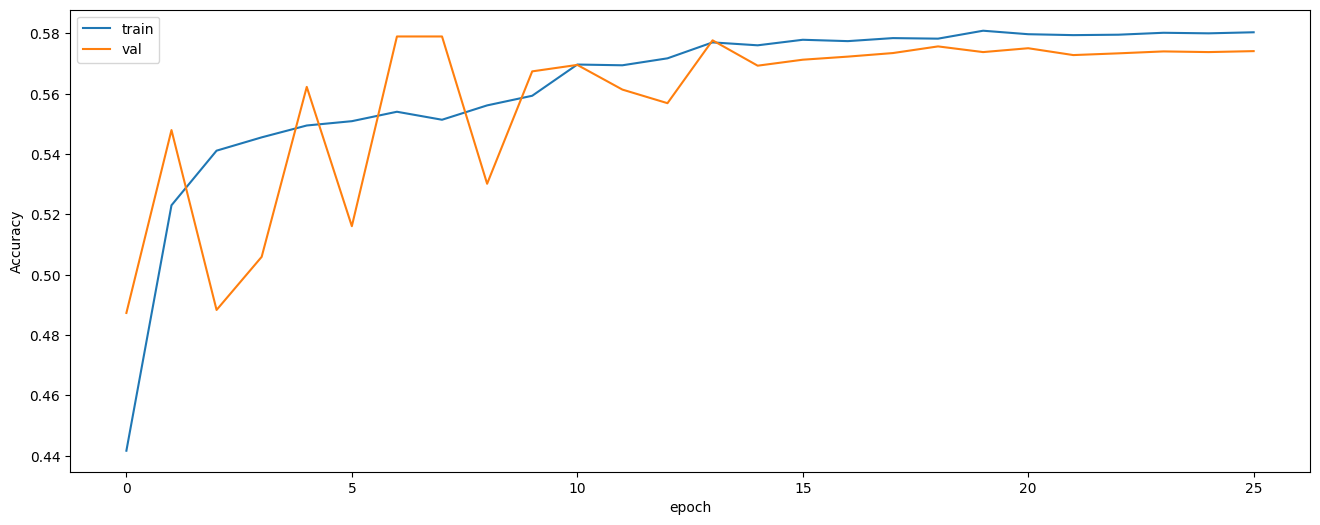

In [137]:
plt.figure(figsize=(16,6))
plt.plot(metrics['train_accs'], label='train');
plt.plot(metrics['valid_accs'], label='val');
plt.ylabel('Accuracy');
plt.xlabel('epoch');
plt.legend();

In [138]:
print("Accuracy de l'ensemble d'entraînement :", get_accuracy(model(data_process_train), y_train))
print("Accuracy de l'ensemble de test :", get_accuracy(model(data_process_test), y_test))

Accuracy de l'ensemble d'entraînement : tensor(0.5826)
Accuracy de l'ensemble de test : tensor(0.5796)


Pas d'amélioration des résultats

**Analyse de la fonction d'activation, avec la totalité des variables**

In [141]:
data = df.drop(['grav_rec', 'an', 'jour', 'date', 'dep', 'grav'], axis=1)
y = df.grav

numerical_features = ['age_usager', 'mois', 'heure', 'lat', 'long']
categorical_features = [col for col in data.columns if col not in numerical_features]
for col in categorical_features:
    data[col] = data[col].astype('int')
data[categorical_features] = data[categorical_features].astype('int')

In [142]:
class TransfoHour(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo[f'{self.column_name}_cos'] = np.cos(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass

class TransfoMonth(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo[f'{self.column_name}_cos'] = np.cos((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass


preprocessor = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', MinMaxScaler(), ['age_usager'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

In [143]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42, stratify=y)
data_train, data_val, y_train, y_val = train_test_split(data_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

data_process_train = preprocessor.fit_transform(data_train)
data_process_val = preprocessor.transform(data_val)
data_process_test = preprocessor.transform(data_test)

display(data_process_train.head())

BATCH_SIZE = 64
NUM_FEATURES = len(data_process_train.columns)
NUM_CLASSES = 4
print((f"Batch size : {BATCH_SIZE}, Nb features : {NUM_FEATURES},  Nb classes : {NUM_CLASSES}"))

data_process_train = torch.tensor(data_process_train.values, dtype=torch.float32).to(device)
data_process_val = torch.tensor(data_process_val.values, dtype=torch.float32).to(device)
data_process_test = torch.tensor(data_process_test.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.astype('int').values, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val.astype('int').values, dtype=torch.float32).to(device)

train_dt = TabularDataset(data=data_process_train, labels=y_train)
val_dt = TabularDataset(data=data_process_val, labels=y_val)
test_dt = TabularDataset(data=data_process_test, labels=y_test)
train_dl = DataLoader(train_dt, BATCH_SIZE, shuffle = True)
val_dl = DataLoader(val_dt, 1, shuffle = False)
test_dl = DataLoader(test_dt, 1, shuffle = False)

,transfo_heure__heure_sin,transfo_heure__heure_cos,transfo_mois__mois_sin,transfo_mois__mois_cos,transfo_lat_long__lat,transfo_lat_long__long,transfo_age_usager__age_usager,remainder__lum,remainder__agg,remainder__int,...,remainder__eq_ceinture,remainder__eq_casque,remainder__eq_siege,remainder__eq_gilet,remainder__eq_airbag,remainder__eq_gants,remainder__eq_indetermine,remainder__eq_autre,remainder__jour_chome,remainder__prox_pt_choc
367203,1.224647e-16,-1.000000,0.000000e+00,1.000000e+00,0.291093,0.027916,0.609091,0,1,0,...,0,0,0,0,0,0,1,0,1,0
165009,-9.659258e-01,-0.258819,8.660254e-01,-5.000000e-01,0.676458,-0.006907,0.381818,0,0,1,...,1,0,0,0,0,0,0,0,1,0
102923,-5.000000e-01,-0.866025,8.660254e-01,-5.000000e-01,0.271712,-0.046623,0.381818,0,1,1,...,0,1,0,0,0,1,0,0,1,1
389410,-8.660254e-01,-0.500000,1.000000e+00,6.123234e-17,0.201869,1.542802,0.209091,0,1,1,...,1,0,0,0,0,0,1,0,0,0
85702,8.660254e-01,-0.500000,1.224647e-16,-1.000000e+00,-0.047079,-0.248779,0.509091,0,1,1,...,0,0,0,0,0,0,0,0,0,0


Batch size : 64, Nb features : 37,  Nb classes : 4


In [144]:
model = NeuralNetClassifier(
    module=Multiclass,
    criterion=nn.CrossEntropyLoss(weight=class_weights, reduction='mean'),
    optimizer=optim.SGD,
    max_epochs=20,
    batch_size=64,
    verbose=True
)

In [145]:
print(model.initialize())

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Multiclass(
    (layer1): Linear(in_features=25, out_features=70, bias=True)
    (layer2): ReLU()
    (layer3): Linear(in_features=70, out_features=140, bias=True)
    (layer4): ReLU()
    (layer5): Dropout(p=0.2, inplace=False)
    (layer6): Linear(in_features=140, out_features=70, bias=True)
    (layer7): ReLU()
    (layer8): Linear(in_features=70, out_features=35, bias=True)
    (layer9): ReLU()
    (layer10): Dropout(p=0.2, inplace=False)
    (layer11): Linear(in_features=35, out_features=14, bias=True)
    (layer12): ReLU()
    (layer13): Linear(in_features=14, out_features=4, bias=True)
  ),
)


In [130]:
# define the grid search parameters
param_grid = {
    'module__activation': [ nn.ReLU, nn.GELU, nn.Softplus, nn.Softsign, nn.Tanh]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1 ,cv=3)
grid_result = grid.fit(data_process_train, y_train.long())

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3853       0.4034        1.3846  7.0984
      2        1.3847       0.4038        1.3839  6.8615
      3        1.3838       0.4486        1.3826  7.0193
      4        1.3814       0.4094        1.3776  8.9727
      5        1.3675       0.3938        1.3526  7.8935
      6        1.3354       0.4209        1.3169  7.7136
      7        1.2973       0.4584        1.2771  7.7621
      8        1.2700       0.4740        1.2598  7.9333
      9        1.2578       0.4924        1.2494  7.8175
     10        1.2484       0.4835        1.2444  8.3864
     11        1.2427       0.5001        1.2372  7.9651
     12        1.2383       0.5142        1.2316  7.6284
     13        1.2334       0.4936        1.2307  7.9805
     14        1.2300       0.5132        1.2259  7.7640
     15        1.2268       0.5130        1.2219  8.0013
     16        1.2231       0.5

In [131]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.504127 using {'module__activation': <class 'torch.nn.modules.activation.ReLU'>}
0.504127 (0.018339) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>}
0.451424 (0.012876) with: {'module__activation': <class 'torch.nn.modules.activation.GELU'>}
0.410249 (0.004709) with: {'module__activation': <class 'torch.nn.modules.activation.Softplus'>}
0.500286 (0.026551) with: {'module__activation': <class 'torch.nn.modules.activation.Softsign'>}
0.503456 (0.029505) with: {'module__activation': <class 'torch.nn.modules.activation.Tanh'>}


**Analyse du taux de dropout**

In [151]:
class Multiclass(nn.Module):
    def __init__(self, activation=nn.ReLU, dropout_rate=0.5):
        super().__init__()
        self.layer1 = nn.Linear(37, 70)
        self.layer2 = activation()
        self.layer3 = nn.Linear(70, 140)
        self.layer4 = activation()
        self.layer5 = nn.Dropout(p=dropout_rate)
        self.layer6 = nn.Linear(140, 70)
        self.layer7 = activation()
        self.layer8 = nn.Linear(70, 35)
        self.layer9 = activation()
        self.layer10 = nn.Dropout(p=dropout_rate)
        self.layer11= nn.Linear(35, 14)
        self.layer12= activation()
        self.layer13= nn.Linear(14, 4)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        return F.softmax(x, dim=1)

In [152]:
model = NeuralNetClassifier(
    module=Multiclass,
    criterion=nn.CrossEntropyLoss(weight=class_weights, reduction='mean'),
    optimizer=optim.SGD,
    max_epochs=20,
    batch_size=64,
    verbose=True
)


In [134]:
# define the grid search parameters
param_grid = {
    'module__dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(data_process_train, y_train.long())

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.3851       0.1566        1.3840  11.6553
      2        1.3832       0.4548        1.3813  11.9507
      3        1.3768       0.3812        1.3647  12.5874
      4        1.3302       0.4188        1.2803  11.9894
      5        1.2690       0.4764        1.2502  12.6474
      6        1.2494       0.4799        1.2400  12.4976
      7        1.2388       0.4920        1.2322  12.1936
      8        1.2316       0.4958        1.2267  11.4135
      9        1.2259       0.4849        1.2238  12.1705
     10        1.2204       0.5055        1.2148  12.0075
     11        1.2165       0.5226        1.2094  12.2892
     12        1.2129       0.5336        1.2059  11.6102
     13        1.2100       0.5271        1.2043  11.4161
     14        1.2064       0.5110        1.2048  13.0020
     15        1.2045       0.5368        1.2008  12.6085
     16       

In [135]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.512884 using {'module__dropout_rate': 0.2}
0.491414 (0.036600) with: {'module__dropout_rate': 0.0}
0.498092 (0.031979) with: {'module__dropout_rate': 0.1}
0.512884 (0.023770) with: {'module__dropout_rate': 0.2}
0.491067 (0.018950) with: {'module__dropout_rate': 0.3}
0.474048 (0.012673) with: {'module__dropout_rate': 0.4}
0.496750 (0.031558) with: {'module__dropout_rate': 0.5}
0.507961 (0.021116) with: {'module__dropout_rate': 0.6}
0.508099 (0.013832) with: {'module__dropout_rate': 0.7}
0.473963 (0.041078) with: {'module__dropout_rate': 0.8}
0.464911 (0.012024) with: {'module__dropout_rate': 0.9}


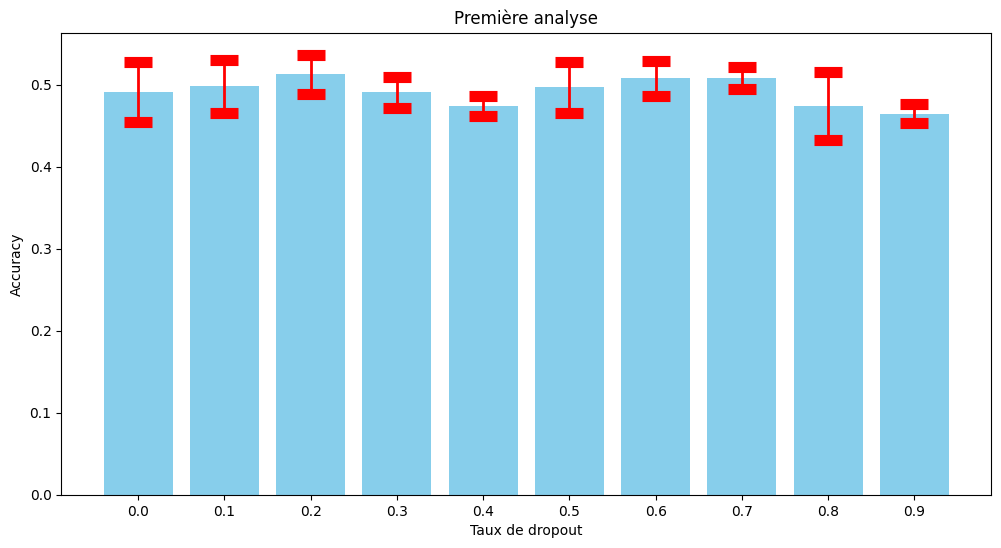

In [146]:
plt.figure(figsize=(12,6))
plt.title('Première analyse')
moy = [0.491414, 0.498092 , 0.512884 ,0.491067 ,0.474048 ,0.496750 ,0.507961 ,0.508099 ,0.473963 ,0.464911 ]
std = [0.036600, 0.031979, 0.023770, 0.018950, 0.012673, 0.031558, 0.021116, 0.013832,0.041078, 0.012024 ]
plt.bar(range(10), moy , color = 'skyblue')
plt.errorbar(range(10), moy , yerr = std,
    fmt = 'none', capsize = 10, ecolor = 'red', elinewidth = 2, capthick = 8)
plt.xticks(range(10), labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]);
plt.xlabel('Taux de dropout');
plt.ylabel('Accuracy');

Deuxième analyse

In [136]:
model = NeuralNetClassifier(
    module=Multiclass,
    criterion=nn.CrossEntropyLoss(weight=class_weights, reduction='mean'),
    optimizer=optim.SGD,
    max_epochs=20,
    batch_size=64,
    verbose=True
)

In [139]:
# define the grid search parameters
param_grid = {
    'module__dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(data_process_train, y_train.long())

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.3864       0.4035        1.3852  15.6172
      2        1.3846       0.4343        1.3835  12.8530
      3        1.3821       0.4268        1.3790  12.1537
      4        1.3627       0.3871        1.3157  12.0330
      5        1.2820       0.4546        1.2583  15.8065
      6        1.2554       0.4721        1.2453  13.5647
      7        1.2450       0.4896        1.2372  13.2563
      8        1.2372       0.4863        1.2316  15.6457
      9        1.2311       0.5068        1.2250  14.8192
     10        1.2260       0.4848        1.2262  15.5066
     11        1.2207       0.4744        1.2232  14.5109
     12        1.2161       0.4900        1.2165  14.8666
     13        1.2125       0.5018        1.2120  14.2364
     14        1.2079       0.4986        1.2101  13.3459
     15        1.2056       0.5310        1.2026  12.5845
     16       

In [140]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.511401 using {'module__dropout_rate': 0.1}
0.482827 (0.041111) with: {'module__dropout_rate': 0.0}
0.511401 (0.020863) with: {'module__dropout_rate': 0.1}
0.489579 (0.019401) with: {'module__dropout_rate': 0.2}
0.482980 (0.024210) with: {'module__dropout_rate': 0.3}
0.503371 (0.027795) with: {'module__dropout_rate': 0.4}
0.503484 (0.023555) with: {'module__dropout_rate': 0.5}
0.505745 (0.027614) with: {'module__dropout_rate': 0.6}
0.487403 (0.003193) with: {'module__dropout_rate': 0.7}
0.479952 (0.028328) with: {'module__dropout_rate': 0.8}
0.484194 (0.005500) with: {'module__dropout_rate': 0.9}


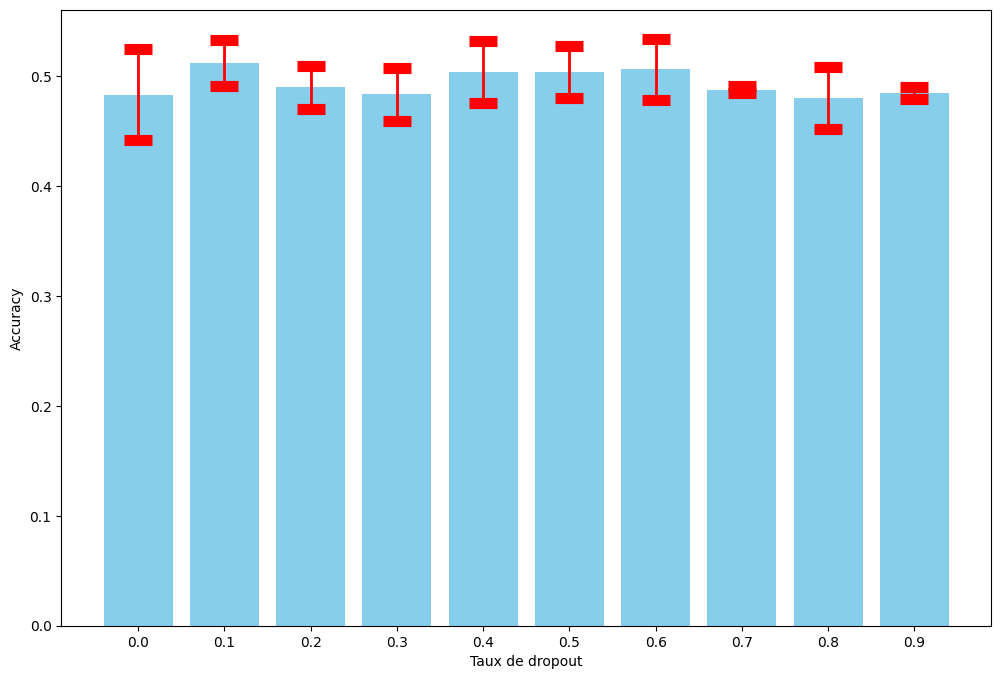

In [152]:
plt.bar(range(10), grid_result.cv_results_['mean_test_score'], color = 'skyblue')
plt.errorbar(range(10), grid_result.cv_results_['mean_test_score'] , yerr = grid_result.cv_results_['std_test_score'],
    fmt = 'none', capsize = 10, ecolor = 'red', elinewidth = 2, capthick = 8)
plt.xticks(range(10), labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]);
plt.xlabel('Taux de dropout');
plt.ylabel('Accuracy');

Si l'on intègre les écarts-types, on s'aperçoit que le taux de dropout a relativement peu d'influence sur la performance du modèle. 
Cela explique pourquoi les 2 tentatives conduisent à 2 meilleurs candidats différents.
Un léger dropout semble permettre de diminuer l'écart type en fonction de l'échantillon considéré.

**Analyse du nombre de neurones**

In [33]:
class Multiclass(nn.Module):
    def __init__(self, activation=nn.ReLU, dropout_rate=0.1, n_neurones = 70):
        super().__init__()
        self.layer1 = nn.Linear(37, n_neurones)
        self.layer2 = activation()
        self.layer3 = nn.Linear(n_neurones, 2*n_neurones)
        self.layer4 = activation()
        self.layer5 = nn.Dropout(p=dropout_rate)
        self.layer6 = nn.Linear(2*n_neurones, n_neurones)
        self.layer7 = activation()
        self.layer8 = nn.Linear(n_neurones, int(0.5*n_neurones))
        self.layer9 = activation()
        self.layer10 = nn.Dropout(p=dropout_rate)
        self.layer11= nn.Linear(int(0.5*n_neurones), int(0.25*n_neurones))
        self.layer12= activation()
        self.layer13= nn.Linear(int(0.25*n_neurones), 4)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        return F.softmax(x, dim=1)

In [154]:
model = NeuralNetClassifier(
    module=Multiclass,
    criterion=nn.CrossEntropyLoss(weight=class_weights, reduction='mean'),
    optimizer=optim.SGD,
    max_epochs=20,
    batch_size=64,
    verbose=True
)

In [155]:
# define the grid search parameters
param_grid = {
    'module__n_neurones': [70,300,800,1500]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(data_process_train, y_train.long())

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.3836       0.4053        1.3786  54.4880
      2        1.3346       0.4522        1.2680  52.8133
      3        1.2525       0.5166        1.2365  54.5090
      4        1.2337       0.5154        1.2234  55.8853
      5        1.2225       0.5178        1.2162  59.2106
      6        1.2134       0.5321        1.2068  57.5107
      7        1.2074       0.5211        1.2034  77.4396
      8        1.2020       0.5649        1.1977  103.9818
      9        1.1990       0.5648        1.1958  103.4724
     10        1.1941       0.5584        1.1930  97.7989
     11        1.1920       0.5597        1.1915  77.8722
     12        1.1890       0.5534        1.1904  96.3077
     13        1.1867       0.5535        1.1892  95.5038
     14        1.1839       0.5607        1.1891  100.6455
     15        1.1823       0.5527        1.1884  102.6255
     16   

In [156]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.522739 using {'module__n_neurones': 800}
0.508703 (0.026197) with: {'module__n_neurones': 70}
0.504517 (0.024791) with: {'module__n_neurones': 300}
0.522739 (0.022373) with: {'module__n_neurones': 800}
0.518106 (0.032010) with: {'module__n_neurones': 1500}


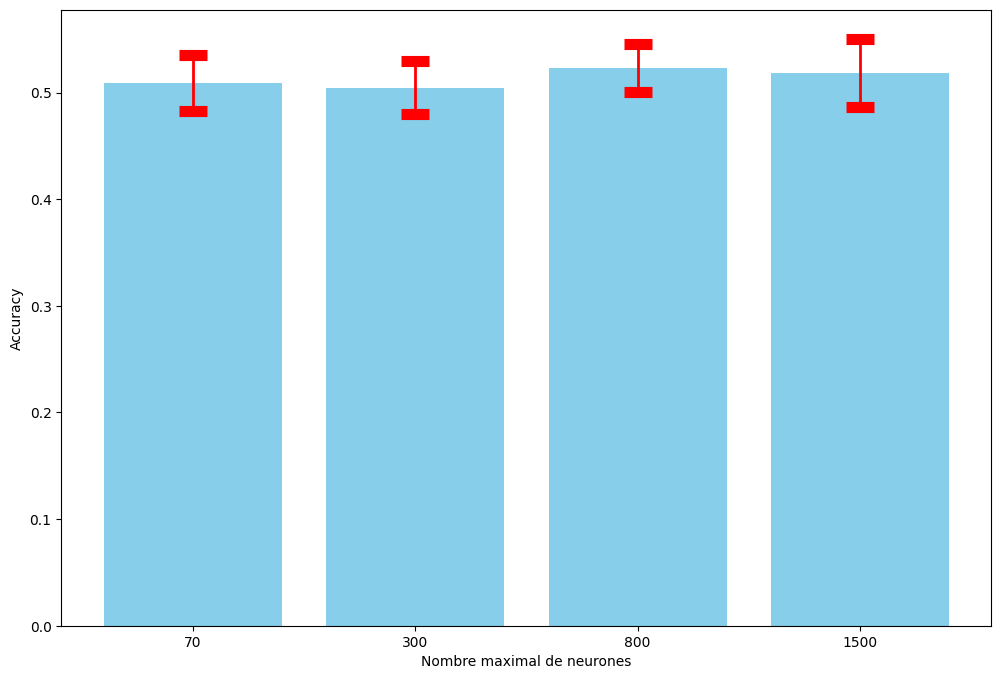

In [157]:
plt.bar(range(4), grid_result.cv_results_['mean_test_score'], color = 'skyblue')
plt.errorbar(range(4), grid_result.cv_results_['mean_test_score'] , yerr = grid_result.cv_results_['std_test_score'],
    fmt = 'none', capsize = 10, ecolor = 'red', elinewidth = 2, capthick = 8)
plt.xticks(range(4), labels=[70,300,800,1500]);
plt.xlabel('Nombre maximal de neurones');
plt.ylabel('Accuracy');

**Modèle avec 800 neurones**

In [34]:
# loss metric and optimizer
LEARNING_RATE = 0.1
model = Multiclass(n_neurones=800, dropout_rate=0.1).to(device)
class_weights = []
for i in range(4):
  Nb_class = y_train[y_train == i].shape[0]
  class_weights.append(y_train.shape[0] / (4*Nb_class))
class_weights = [class_weights[i] for i in range(len(class_weights))]
class_weights = torch.FloatTensor(class_weights).to(device)
print("class_weights:", class_weights)
loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction='mean').to(device)

#loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.25, patience=2, threshold=0.001, min_lr=1e-4)

class_weights: tensor([0.6057, 0.6197, 1.5969, 9.1614])


In [36]:
n_epochs = 50
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc, train_f1 = train(train_dl, model, loss_fn, optimizer, device)
    valid_loss, valid_acc, valid_f1 = evaluate(val_dl, model, loss_fn, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "../../../data/saved_models/dict_model_pytorch_opt.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}, train_f1: {train_f1:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}, valid_f1: {valid_f1:.3f}")

training...:   0%|          | 0/4402 [00:00<?, ?it/s]

evaluating...: 100%|██████████| 31300/31300 [01:36<00:00, 322.99it/s]


lr : 0.1
epoch: 0
train_loss: 1.263, train_acc: 0.495, train_f1: 0.494
valid_loss: 1.230, valid_acc: 0.485, valid_f1: 0.485


evaluating...: 100%|██████████| 31300/31300 [01:29<00:00, 348.91it/s]


lr : 0.1
epoch: 1
train_loss: 1.210, train_acc: 0.542, train_f1: 0.558
valid_loss: 1.139, valid_acc: 0.590, valid_f1: 0.590


evaluating...: 100%|██████████| 31300/31300 [01:31<00:00, 342.81it/s]


lr : 0.1
epoch: 2
train_loss: 1.196, train_acc: 0.556, train_f1: 0.570
valid_loss: 1.181, valid_acc: 0.544, valid_f1: 0.544


evaluating...: 100%|██████████| 31300/31300 [01:29<00:00, 349.24it/s]


lr : 0.1
epoch: 3
train_loss: 1.188, train_acc: 0.567, train_f1: 0.581
valid_loss: 1.151, valid_acc: 0.575, valid_f1: 0.575


evaluating...: 100%|██████████| 31300/31300 [01:28<00:00, 354.37it/s]


lr : 0.025
epoch: 4
train_loss: 1.183, train_acc: 0.569, train_f1: 0.583
valid_loss: 1.170, valid_acc: 0.552, valid_f1: 0.552


evaluating...: 100%|██████████| 31300/31300 [01:23<00:00, 372.69it/s]


lr : 0.025
epoch: 5
train_loss: 1.166, train_acc: 0.585, train_f1: 0.600
valid_loss: 1.153, valid_acc: 0.573, valid_f1: 0.573


evaluating...: 100%|██████████| 31300/31300 [01:24<00:00, 370.38it/s]


lr : 0.025
epoch: 6
train_loss: 1.163, train_acc: 0.589, train_f1: 0.603
valid_loss: 1.134, valid_acc: 0.590, valid_f1: 0.590


evaluating...: 100%|██████████| 31300/31300 [01:25<00:00, 368.01it/s]


lr : 0.00625
epoch: 7
train_loss: 1.160, train_acc: 0.592, train_f1: 0.606
valid_loss: 1.138, valid_acc: 0.589, valid_f1: 0.589


evaluating...: 100%|██████████| 31300/31300 [01:23<00:00, 373.74it/s]


lr : 0.00625
epoch: 8
train_loss: 1.153, train_acc: 0.597, train_f1: 0.611
valid_loss: 1.147, valid_acc: 0.580, valid_f1: 0.580


evaluating...: 100%|██████████| 31300/31300 [01:40<00:00, 310.50it/s]


lr : 0.00625
epoch: 9
train_loss: 1.151, train_acc: 0.599, train_f1: 0.613
valid_loss: 1.148, valid_acc: 0.578, valid_f1: 0.578


evaluating...: 100%|██████████| 31300/31300 [01:48<00:00, 289.05it/s]


lr : 0.0015625
epoch: 10
train_loss: 1.150, train_acc: 0.601, train_f1: 0.615
valid_loss: 1.145, valid_acc: 0.581, valid_f1: 0.581


evaluating...: 100%|██████████| 31300/31300 [01:42<00:00, 306.38it/s]


lr : 0.0015625
epoch: 11
train_loss: 1.146, train_acc: 0.603, train_f1: 0.616
valid_loss: 1.138, valid_acc: 0.589, valid_f1: 0.589


evaluating...: 100%|██████████| 31300/31300 [01:40<00:00, 312.37it/s]


lr : 0.0015625
epoch: 12
train_loss: 1.146, train_acc: 0.604, train_f1: 0.617
valid_loss: 1.138, valid_acc: 0.590, valid_f1: 0.590


evaluating...: 100%|██████████| 31300/31300 [01:45<00:00, 297.38it/s]


lr : 0.000390625
epoch: 13
train_loss: 1.145, train_acc: 0.603, train_f1: 0.617
valid_loss: 1.140, valid_acc: 0.587, valid_f1: 0.587


evaluating...: 100%|██████████| 31300/31300 [02:29<00:00, 208.69it/s]


lr : 0.000390625
epoch: 14
train_loss: 1.144, train_acc: 0.605, train_f1: 0.619
valid_loss: 1.142, valid_acc: 0.585, valid_f1: 0.585


evaluating...: 100%|██████████| 31300/31300 [02:27<00:00, 212.34it/s]


lr : 0.000390625
epoch: 15
train_loss: 1.145, train_acc: 0.605, train_f1: 0.618
valid_loss: 1.141, valid_acc: 0.586, valid_f1: 0.586


evaluating...: 100%|██████████| 31300/31300 [02:24<00:00, 216.08it/s]


lr : 0.0001
epoch: 16
train_loss: 1.144, train_acc: 0.605, train_f1: 0.618
valid_loss: 1.140, valid_acc: 0.587, valid_f1: 0.587


evaluating...: 100%|██████████| 31300/31300 [02:24<00:00, 217.01it/s]


lr : 0.0001
epoch: 17
train_loss: 1.143, train_acc: 0.606, train_f1: 0.620
valid_loss: 1.140, valid_acc: 0.588, valid_f1: 0.588


evaluating...: 100%|██████████| 31300/31300 [02:19<00:00, 224.92it/s]


lr : 0.0001
epoch: 18
train_loss: 1.143, train_acc: 0.606, train_f1: 0.619
valid_loss: 1.140, valid_acc: 0.587, valid_f1: 0.587


evaluating...: 100%|██████████| 31300/31300 [01:22<00:00, 378.82it/s]


lr : 0.0001
epoch: 19
train_loss: 1.144, train_acc: 0.606, train_f1: 0.619
valid_loss: 1.140, valid_acc: 0.587, valid_f1: 0.587


evaluating...: 100%|██████████| 31300/31300 [01:22<00:00, 380.12it/s]


lr : 0.0001
epoch: 20
train_loss: 1.144, train_acc: 0.606, train_f1: 0.619
valid_loss: 1.140, valid_acc: 0.588, valid_f1: 0.588


evaluating...: 100%|██████████| 31300/31300 [01:22<00:00, 380.57it/s]


lr : 0.0001
epoch: 21
train_loss: 1.144, train_acc: 0.606, train_f1: 0.619
valid_loss: 1.140, valid_acc: 0.587, valid_f1: 0.587


evaluating...: 100%|██████████| 31300/31300 [01:22<00:00, 377.12it/s]


lr : 0.0001
epoch: 22
train_loss: 1.144, train_acc: 0.605, train_f1: 0.619
valid_loss: 1.140, valid_acc: 0.588, valid_f1: 0.588


evaluating...: 100%|██████████| 31300/31300 [01:21<00:00, 381.73it/s]


lr : 0.0001
epoch: 23
train_loss: 1.144, train_acc: 0.606, train_f1: 0.619
valid_loss: 1.140, valid_acc: 0.587, valid_f1: 0.587


evaluating...: 100%|██████████| 31300/31300 [01:23<00:00, 373.33it/s]


lr : 0.0001
epoch: 24
train_loss: 1.143, train_acc: 0.606, train_f1: 0.619
valid_loss: 1.140, valid_acc: 0.587, valid_f1: 0.587


evaluating...: 100%|██████████| 31300/31300 [01:23<00:00, 373.74it/s]


lr : 0.0001
epoch: 25
train_loss: 1.144, train_acc: 0.606, train_f1: 0.619
valid_loss: 1.140, valid_acc: 0.588, valid_f1: 0.588


evaluating...: 100%|██████████| 31300/31300 [01:44<00:00, 300.44it/s]


lr : 0.0001
epoch: 26
train_loss: 1.144, train_acc: 0.606, train_f1: 0.619
valid_loss: 1.140, valid_acc: 0.588, valid_f1: 0.588


evaluating...: 100%|██████████| 31300/31300 [01:40<00:00, 312.97it/s]


lr : 0.0001
epoch: 27
train_loss: 1.144, train_acc: 0.605, train_f1: 0.618
valid_loss: 1.139, valid_acc: 0.588, valid_f1: 0.588


evaluating...: 100%|██████████| 31300/31300 [01:40<00:00, 311.28it/s]


lr : 0.0001
epoch: 28
train_loss: 1.143, train_acc: 0.606, train_f1: 0.619
valid_loss: 1.140, valid_acc: 0.588, valid_f1: 0.588


evaluating...: 100%|██████████| 31300/31300 [01:37<00:00, 321.42it/s]


lr : 0.0001
epoch: 29
train_loss: 1.143, train_acc: 0.607, train_f1: 0.620
valid_loss: 1.140, valid_acc: 0.588, valid_f1: 0.588


evaluating...: 100%|██████████| 31300/31300 [01:40<00:00, 312.49it/s]


lr : 0.0001
epoch: 30
train_loss: 1.143, train_acc: 0.605, train_f1: 0.619
valid_loss: 1.140, valid_acc: 0.587, valid_f1: 0.587


evaluating...: 100%|██████████| 31300/31300 [01:41<00:00, 309.24it/s]


lr : 0.0001
epoch: 31
train_loss: 1.143, train_acc: 0.606, train_f1: 0.619
valid_loss: 1.140, valid_acc: 0.587, valid_f1: 0.587


training...:   9%|▉         | 411/4402 [00:08<01:24, 47.32it/s]


KeyboardInterrupt: 

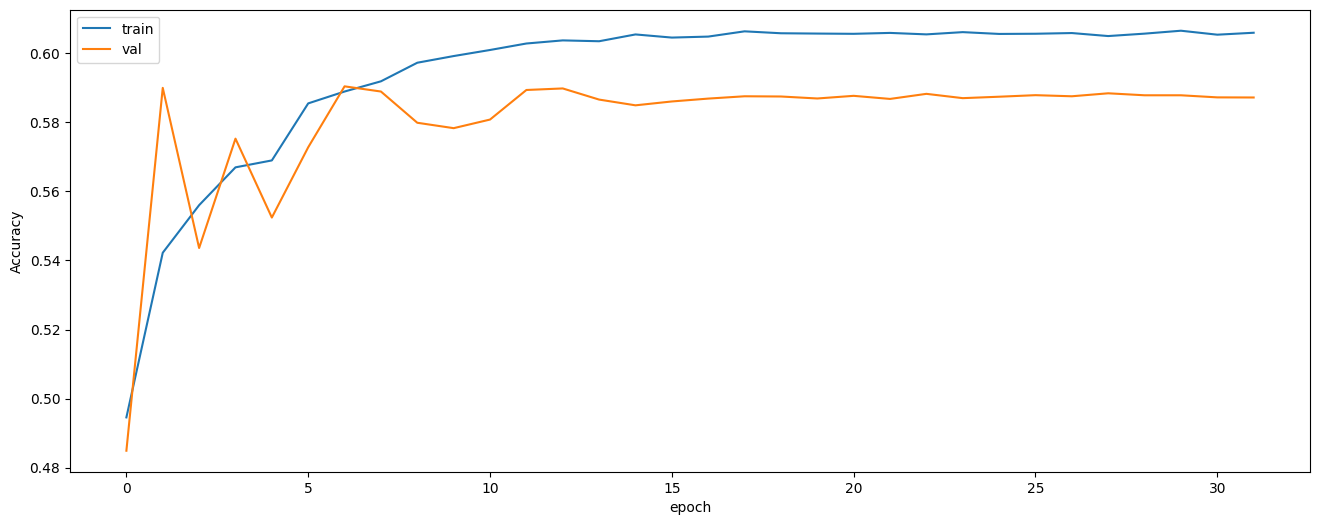

In [37]:
plt.figure(figsize=(16,6))
plt.plot(metrics['train_accs'], label='train');
plt.plot(metrics['valid_accs'], label='val');
plt.ylabel('Accuracy');
plt.xlabel('epoch');
plt.legend();

In [38]:
predictions = model(data_process_test)

In [39]:
y_pred_opt = torch.argmax(torch.sigmoid(predictions),dim=1)
y_pred_df = pd.DataFrame(y_pred_opt.numpy())
y_pred_df.value_counts()

0
0    58191
1    38023
2    23646
3    14281
Name: count, dtype: int64

In [40]:
print("Accuracy de l'ensemble d'entraînement :", get_accuracy(model(data_process_train), y_train))
print("Accuracy de l'ensemble de test :", get_accuracy(model(data_process_test), y_test))

Accuracy de l'ensemble d'entraînement : tensor(0.6060)
Accuracy de l'ensemble de test : tensor(0.5929)


In [41]:
cr= classification_report(y_test, y_pred_opt, target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'])
print(cr)

                precision    recall  f1-score   support

      Indemnes       0.73      0.77      0.75     55365
Blessés légers       0.68      0.48      0.56     54116
Blessés graves       0.38      0.42      0.40     21000
          Tués       0.14      0.56      0.23      3660

      accuracy                           0.59    134141
     macro avg       0.48      0.56      0.49    134141
  weighted avg       0.64      0.59      0.61    134141



In [42]:
cr= classification_report(y_test, y_pred_opt, target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'],output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
print(df_cr)
df_cr.to_csv('../../../data/img/' + 'dnn_pytorch_opt_report' + '.csv')

                precision    recall  f1-score        support
Indemnes         0.734409  0.771896  0.752686   55365.000000
Blessés légers   0.678563  0.476772  0.560045   54116.000000
Blessés graves   0.376258  0.423667  0.398558   21000.000000
Tués             0.143897  0.561475  0.229084    3660.000000
accuracy         0.592578  0.592578  0.592578       0.592578
macro avg        0.483282  0.558452  0.485093  134141.000000
weighted avg     0.639698  0.592578  0.605244  134141.000000


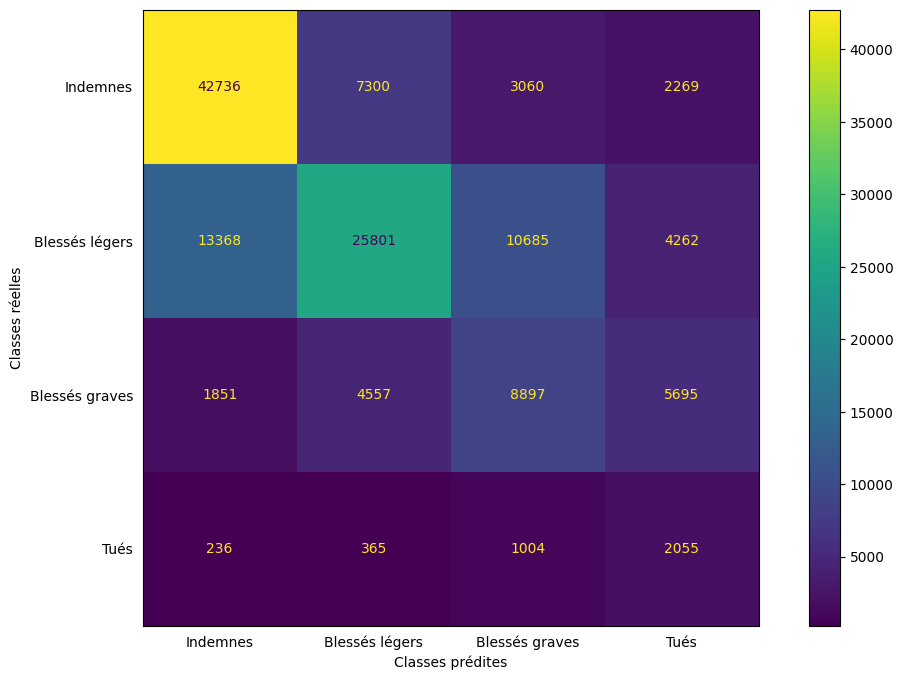

In [43]:
cm = confusion_matrix(y_test, y_pred_opt) 
disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués']
    )

#disp.ax_.set(xlabel='Classes prédites', ylabel='Classes réelles')
disp.plot()
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')
plt.tick_params(left = False, bottom = False) 
plt.rcParams["figure.figsize"] = (13, 8)
plt.savefig('../../../data/img/' + f'dnn_pytorch_opt_confusion_matrix' + '.jpg')

In [31]:
loaded_model = Multiclass()
loaded_model.load_state_dict(torch.load("../../../data/saved_models/dict_model_pytorch.pt"))
loaded_model.eval()

Multiclass(
  (layer1): Linear(in_features=37, out_features=70, bias=True)
  (layer2): ReLU()
  (layer3): Linear(in_features=70, out_features=140, bias=True)
  (layer4): ReLU()
  (layer5): Dropout(p=0.2, inplace=False)
  (layer6): Linear(in_features=140, out_features=70, bias=True)
  (layer7): ReLU()
  (layer8): Linear(in_features=70, out_features=35, bias=True)
  (layer9): ReLU()
  (layer10): Dropout(p=0.2, inplace=False)
  (layer11): Linear(in_features=35, out_features=14, bias=True)
  (layer12): ReLU()
  (layer13): Linear(in_features=14, out_features=4, bias=True)
)

In [44]:
epoch

32